### Importando librerias y funciones

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from datetime import datetime, timedelta

### Cargando la base de datos

In [2]:
training_set = pd.read_csv('HOOD.csv', sep=';')


### Definiendo la variable 'date' como fecha y reorganizando la serie de forma ascendete

In [3]:
training_set.info()
training_set['date']=pd.to_datetime(training_set['date'])
training_set= training_set.sort_values(by="date",ascending=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 268 entries, 0 to 267
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        268 non-null    object 
 1   close_last  268 non-null    float64
 2   volume      268 non-null    int64  
 3   open        268 non-null    float64
 4   high        268 non-null    float64
 5   low         268 non-null    float64
dtypes: float64(4), int64(1), object(1)
memory usage: 12.7+ KB


### Graficando la serie correspondiente al valor de las acciones de Robin Hood

<Figure size 432x288 with 0 Axes>

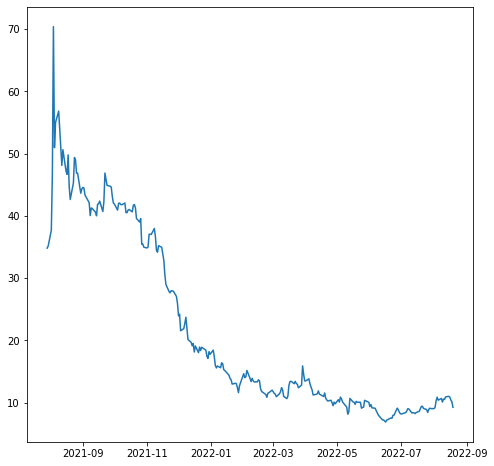

In [4]:
plt.suptitle('Valor de las acciones de Robin Hood')
figure(figsize=(8,8))
plt.plot('date', 'close_last', data=training_set )
plt.show()

### Se aprecia claramente un desplome en el valor de las acciones de Robin Hood. Se observa una clara tendencia a la baja.

In [5]:
training_set = training_set.iloc[:,1:2].values


### Particionando la data en muestra test y muestra train

In [6]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

sc = MinMaxScaler()
training_data = sc.fit_transform(training_set) 

seq_length = 12  
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.75)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

### Definiendo el modelo de red neuronal LSTM

In [7]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

### Definiendo los hiperparámetros y graficando la función loss Vs Epoch

In [8]:

num_epochs = 350
input_size = 1
hidden_size = 15
num_layers = 1

num_classes = 1
learning_rate = 0.01


lstm = LSTM(num_classes, input_size, hidden_size, num_layers)
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
Loss=[]
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY)
    Loss.append(loss.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 10 == 0 and epoch !=0: 
      print("Epoch ", epoch, "loss ", loss.item())

Epoch  10 loss  0.02833256497979164
Epoch  20 loss  0.003258297685533762
Epoch  30 loss  0.002065971028059721
Epoch  40 loss  0.0013324788305908442
Epoch  50 loss  0.0006615365855395794
Epoch  60 loss  0.0005824177642352879
Epoch  70 loss  0.0005354280583560467
Epoch  80 loss  0.0005040335236117244
Epoch  90 loss  0.000489099882543087
Epoch  100 loss  0.0004789579543285072
Epoch  110 loss  0.00047450923011638224
Epoch  120 loss  0.00047138737863861024
Epoch  130 loss  0.0004690069181378931
Epoch  140 loss  0.0004667227913159877
Epoch  150 loss  0.00046447099884971976
Epoch  160 loss  0.00046219115029089153
Epoch  170 loss  0.0004598767845891416
Epoch  180 loss  0.00045753191807307303
Epoch  190 loss  0.0004551603633444756
Epoch  200 loss  0.0004527659621089697
Epoch  210 loss  0.00045035299262963235
Epoch  220 loss  0.00044792520930059254
Epoch  230 loss  0.0004454865993466228
Epoch  240 loss  0.0004430409462656826
Epoch  250 loss  0.000440591829828918
Epoch  260 loss  0.00043814306263

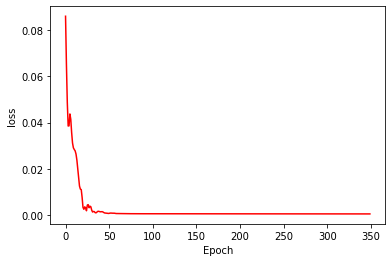

In [9]:
plt.plot(Loss, label="loss function", color='red')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.show()

### Estableciendo las predicciones y comparando estas con los valores reales de la serie, lo que se puede visualizar el en grafico

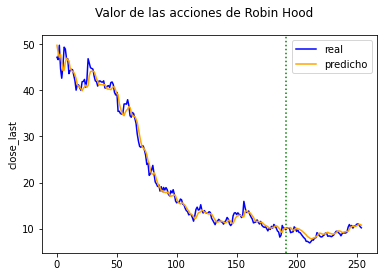

In [18]:
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy() 
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

plt.axvline(x=train_size, c='green', linestyle=':')
plt.plot(dataY_plot, color='blue', label='real')
plt.ylabel('close_last')
plt.plot(data_predict, color='orange', label='predicho')
plt.legend(loc='upper right')
plt.suptitle('Valor de las acciones de Robin Hood')
plt.savefig('Acciones_Robin_Hood.png')
plt.show()


### Calculando el valor del error cuadrático medio para el modelo de deep learning. Según el valor obtenido, el modelo es muy preciso al momento de estimar, el valor de 1.29 indica que existe poca diferencia entre los valores reales y los valores predichos

In [19]:
mean_squared_error(data_predict, dataY_plot)

1.2912447